ресурс: https://www.kaggle.com/datasets/chilledwanker/loan-approval-prediction/data

# Setup & Imports

In [19]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

print("Libraries loaded.")

Libraries loaded.


# Load Dataset

In [30]:
df = pd.read_csv("credit_risk_dataset.csv")
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


# Data Understanding and Preprocessing

In [31]:
# Basic information
print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"Shape: {df.shape}")
print(f"\nData types:")
print(df.dtypes)
print(f"\nMissing values:")
missing = df.isnull().sum()
print(missing[missing > 0])
print(f"\nTotal missing: {missing.sum()} ({missing.sum()/len(df)*100:.2f}%)")

# Display first few rows
print("\n" + "=" * 80)
print("FIRST 5 ROWS")
print("=" * 80)
print(df.head())

DATASET OVERVIEW
Shape: (32581, 12)

Data types:
person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

Missing values:
person_emp_length     895
loan_int_rate        3116
dtype: int64

Total missing: 4011 (12.31%)

FIRST 5 ROWS
   person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT             

## Data Preprocessing


### 1. Handling Missing Values

In [32]:
# Copy for preprocessing
df_processed = df.copy()

# 1. Handling missing values in loan_int_rate

# Fill missing values with median by loan_grade
df_processed['loan_int_rate'] = df_processed.groupby('loan_grade')['loan_int_rate'].transform(
    lambda x: x.fillna(x.median())
)
# If still missing (e.g., if a grade has all missing), fill with overall median
df_processed['loan_int_rate'] = df_processed['loan_int_rate'].fillna(df_processed['loan_int_rate'].median())

# 2. Handling missing values in person_emp_length

# Fill missing values with median by age group
df_processed['person_emp_length'] = df_processed.groupby(df_processed['person_age'] // 10 * 10)['person_emp_length'].transform(
    lambda x: x.fillna(x.median())
)
# If still missing, fill with overall median
df_processed['person_emp_length'] = df_processed['person_emp_length'].fillna(df_processed['person_emp_length'].median())

# Verify no missing values remain
print(f"\nTotal missing values after imputation: {df_processed.isnull().sum().sum()}")



Total missing values after imputation: 0


### 2. Encode Categorical Variables

In [33]:
# 1. person_home_ownership: RENT, OWN, MORTGAGE, OTHER
# One-hot encoding
df_processed = pd.get_dummies(df_processed, columns=['person_home_ownership'], prefix='home_own')

# 2. loan_intent: PERSONAL, EDUCATION, MEDICAL, VENTURE, HOMEIMPROVEMENT, DEBTCONSOLIDATION
df_processed = pd.get_dummies(df_processed, columns=['loan_intent'], prefix='intent')

# 3. loan_grade: A, B, C, D, E, F, G (ordinal - A is best, G is worst)
grade_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
df_processed['loan_grade_encoded'] = df_processed['loan_grade'].map(grade_mapping)
df_processed = df_processed.drop('loan_grade', axis=1)  # Drop original column

# 4. cb_person_default_on_file: Y, N (binary)
df_processed['cb_person_default_on_file'] = (df_processed['cb_person_default_on_file'] == 'Y').astype(int)

df_processed.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,home_own_MORTGAGE,home_own_OTHER,home_own_OWN,home_own_RENT,intent_DEBTCONSOLIDATION,intent_EDUCATION,intent_HOMEIMPROVEMENT,intent_MEDICAL,intent_PERSONAL,intent_VENTURE,loan_grade_encoded
0,22,59000,123.0,35000,16.02,1,0.59,1,3,False,False,False,True,False,False,False,False,True,False,4
1,21,9600,5.0,1000,11.14,0,0.10,0,2,False,False,True,False,False,True,False,False,False,False,2
2,25,9600,1.0,5500,12.87,1,0.57,0,3,True,False,False,False,False,False,False,True,False,False,3
3,23,65500,4.0,35000,15.23,1,0.53,0,2,False,False,False,True,False,False,False,True,False,False,3
4,24,54400,8.0,35000,14.27,1,0.55,1,4,False,False,False,True,False,False,False,True,False,False,3


### 3. Feature Selection

In [35]:
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif

# Prepare features and target
X = df_processed.drop('loan_status', axis=1)
y = df_processed['loan_status']

print(f"\nOriginal features: {X.shape[1]}")
print(f"Features: {X.columns.tolist()}")

# Calculate Mutual Information
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_df = pd.DataFrame({
    'Feature': X.columns,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

print("\nMutual Information Scores (Top 15):")
print(mi_df.head(15).to_string(index=False))

# Select top k features based on mutual information
# Select features with MI > 0.01
k_best = min(20, len(X.columns))
threshold = 0.01
selected_features = mi_df[mi_df['MI_Score'] > threshold]['Feature'].tolist()

print(f"Selected features: {selected_features}")

# Update X with selected features
X_selected = X[selected_features].copy()

print(f"\nFinal feature set shape: {X_selected.shape}")



Original features: 19
Features: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length', 'home_own_MORTGAGE', 'home_own_OTHER', 'home_own_OWN', 'home_own_RENT', 'intent_DEBTCONSOLIDATION', 'intent_EDUCATION', 'intent_HOMEIMPROVEMENT', 'intent_MEDICAL', 'intent_PERSONAL', 'intent_VENTURE', 'loan_grade_encoded']

Mutual Information Scores (Top 15):
                   Feature  MI_Score
             person_income  0.114151
       loan_percent_income  0.082357
        loan_grade_encoded  0.074732
             loan_int_rate  0.073287
             home_own_RENT  0.030818
         home_own_MORTGAGE  0.018701
                 loan_amnt  0.016506
 cb_person_default_on_file  0.014427
  intent_DEBTCONSOLIDATION  0.006082
         person_emp_length  0.005460
cb_person_cred_hist_length  0.005165
              home_own_OWN  0.004712
            intent_VENTURE  0.003920
            intent_MEDIC

### 4. Scaling and train/test split

In [37]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"\nTrain target distribution:")
print(y_train.value_counts())
print(f"\nTest target distribution:")
print(y_test.value_counts())

# Apply Standard Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print(f"  Scaled train shape: {X_train_scaled.shape}")
print(f"  Scaled test shape: {X_test_scaled.shape}")



Train set: 26,064 samples
Test set: 6,517 samples

Train target distribution:
loan_status
0    20378
1     5686
Name: count, dtype: int64

Test target distribution:
loan_status
0    5095
1    1422
Name: count, dtype: int64
  Scaled train shape: (26064, 8)
  Scaled test shape: (6517, 8)


# Target Distribution

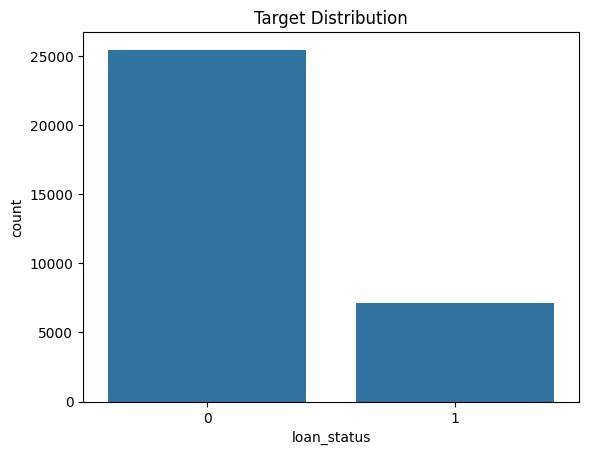

loan_status
0    0.781836
1    0.218164
Name: proportion, dtype: float64

In [38]:
sns.countplot(x=df['loan_status'])
plt.title("Target Distribution")
plt.show()

df['loan_status'].value_counts(normalize=True)

# Model building

## Logstic regression

In [40]:
lr = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)

lr_pred = lr.predict(X_test_scaled)
lr_pred_proba = lr.predict_proba(X_test_scaled)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, lr_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, lr_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, lr_pred_proba):.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, lr_pred, target_names=['No Default', 'Default']))

Accuracy: 0.7901
F1 Score: 0.6155
ROC AUC: 0.8577

Classification Report:
              precision    recall  f1-score   support

  No Default       0.93      0.80      0.86      5095
     Default       0.51      0.77      0.62      1422

    accuracy                           0.79      6517
   macro avg       0.72      0.78      0.74      6517
weighted avg       0.84      0.79      0.80      6517



## Random Forest Model

In [41]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_pred_proba = rf.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, rf_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, rf_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, rf_pred_proba):.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, rf_pred, target_names=['No Default', 'Default']))

Accuracy: 0.8909
F1 Score: 0.7478
ROC AUC: 0.9087

Classification Report:
              precision    recall  f1-score   support

  No Default       0.93      0.93      0.93      5095
     Default       0.75      0.74      0.75      1422

    accuracy                           0.89      6517
   macro avg       0.84      0.84      0.84      6517
weighted avg       0.89      0.89      0.89      6517



## XGBoost Baseline

In [42]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb = XGBClassifier(
    eval_metric="logloss",
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
xgb_pred_proba = xgb.predict_proba(X_test)[:, 1]

print(f"Scale pos weight: {scale_pos_weight:.2f}")
print(f"Accuracy: {accuracy_score(y_test, xgb_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, xgb_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, xgb_pred_proba):.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, xgb_pred, target_names=['No Default', 'Default']))

Scale pos weight: 3.58
Accuracy: 0.8854
F1 Score: 0.7481
ROC AUC: 0.9254

Classification Report:
              precision    recall  f1-score   support

  No Default       0.94      0.91      0.93      5095
     Default       0.72      0.78      0.75      1422

    accuracy                           0.89      6517
   macro avg       0.83      0.85      0.84      6517
weighted avg       0.89      0.89      0.89      6517



# Model Tunning



HYPERPARAMETER TUNING

1. TUNING LOGISTIC REGRESSION
Starting GridSearchCV for Logistic Regression...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

✓ Tuning completed in 12.48 seconds
Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV score: 0.8553

Test Performance:
  Accuracy: 0.7899
  F1 Score: 0.6153
  ROC AUC: 0.8577

2. TUNING RANDOM FOREST
Starting GridSearchCV for Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

✓ Tuning completed in 277.35 seconds
Best parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best CV score: 0.9115

Test Performance:
  Accuracy: 0.8917
  F1 Score: 0.7479
  ROC AUC: 0.9103

3. TUNING XGBOOST
Starting GridSearchCV for XGBoost...
Fitting 5 folds for each of 54 candidates, totalling 270 fits

✓ Tuning completed in 23.56 seconds
Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}
Best CV score: 0.92

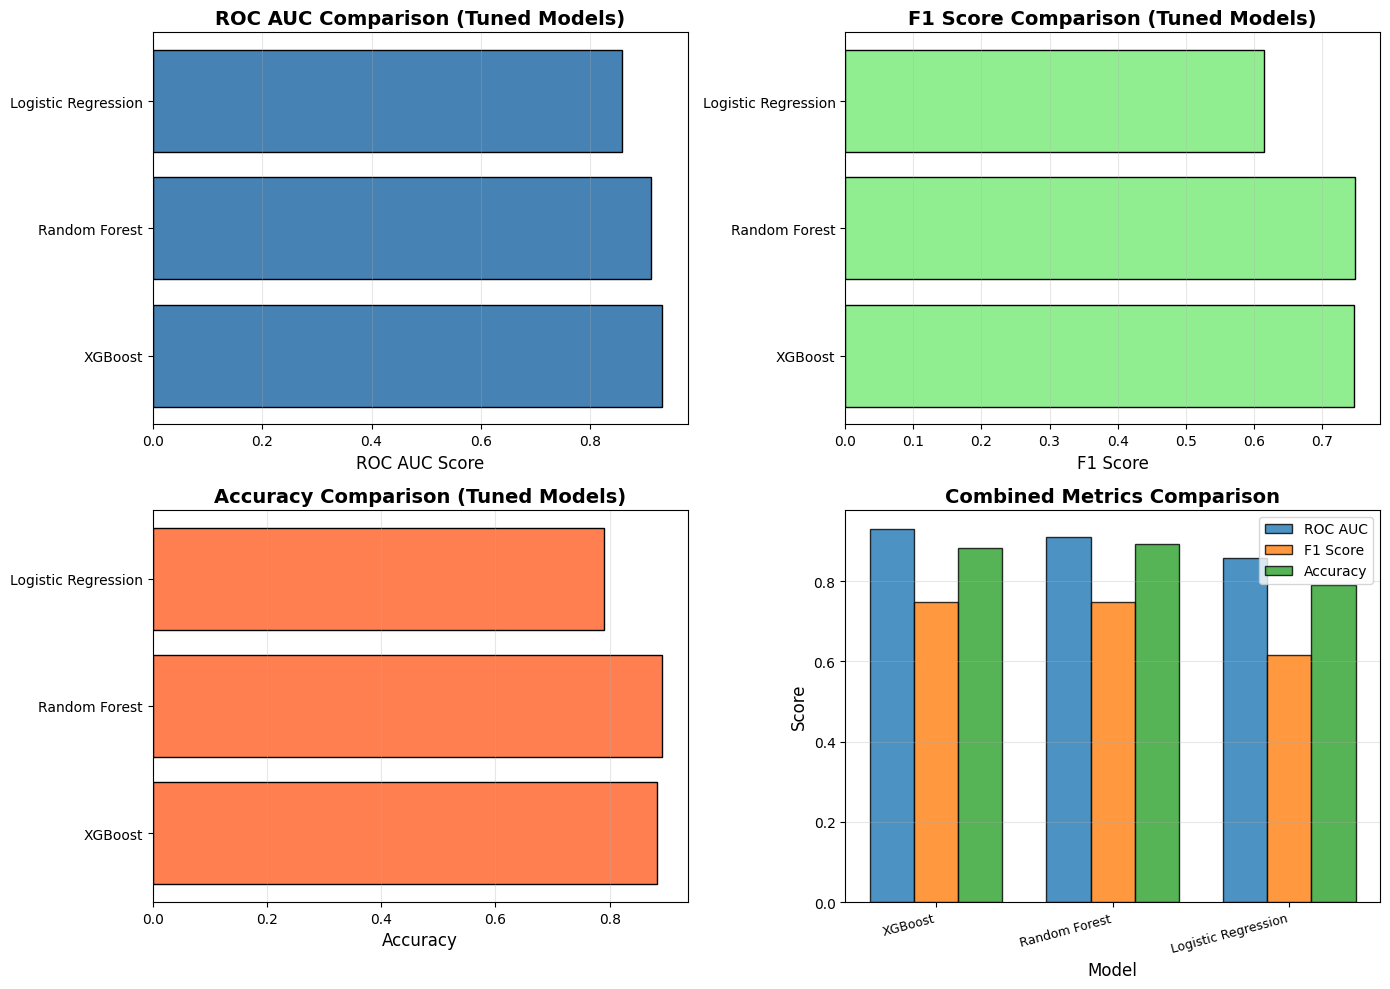


BEST MODEL SELECTION
Best model: XGBoost
  ROC AUC: 0.9310
  F1 Score: 0.7473
  Accuracy: 0.8826


In [ ]:
# Model Tuning with GridSearchCV
# Tuning hyperparameters for all three models to find best configuration

from sklearn.model_selection import GridSearchCV
import time

print("HYPERPARAMETER TUNING")
print("=" * 80)

# 1. Logistic Regression Tuning
print("1. LOGISTIC REGRESSION")

lr_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear'],
    'penalty': ['l2']
}

lr_base = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

start_time = time.time()
lr_grid_search = GridSearchCV(
    lr_base, 
    lr_param_grid, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1,
    verbose=1
)
lr_grid_search.fit(X_train_scaled, y_train)
lr_tuning_time = time.time() - start_time

best_lr = lr_grid_search.best_estimator_
lr_tuned_pred = best_lr.predict(X_test_scaled)
lr_tuned_pred_proba = best_lr.predict_proba(X_test_scaled)[:, 1]

print(f"\nTuning completed in {lr_tuning_time:.2f} seconds")
print(f"Best parameters: {lr_grid_search.best_params_}")
print(f"Best CV score: {lr_grid_search.best_score_:.4f}")
print(f"\nTest Performance:")
print(f"  Accuracy: {accuracy_score(y_test, lr_tuned_pred):.4f}")
print(f"  F1 Score: {f1_score(y_test, lr_tuned_pred):.4f}")
print(f"  ROC AUC: {roc_auc_score(y_test, lr_tuned_pred_proba):.4f}")


# 2. Random Forest Tuning
print("2. RANDOM FOREST")

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_base = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

start_time = time.time()
rf_grid_search = GridSearchCV(
    rf_base,
    rf_param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
rf_grid_search.fit(X_train, y_train)
rf_tuning_time = time.time() - start_time

best_rf = rf_grid_search.best_estimator_
rf_tuned_pred = best_rf.predict(X_test)
rf_tuned_pred_proba = best_rf.predict_proba(X_test)[:, 1]

print(f"\nTuning completed in {rf_tuning_time:.2f} seconds")
print(f"Best parameters: {rf_grid_search.best_params_}")
print(f"Best CV score: {rf_grid_search.best_score_:.4f}")
print(f"\nTest Performance:")
print(f"  Accuracy: {accuracy_score(y_test, rf_tuned_pred):.4f}")
print(f"  F1 Score: {f1_score(y_test, rf_tuned_pred):.4f}")
print(f"  ROC AUC: {roc_auc_score(y_test, rf_tuned_pred_proba):.4f}")


# 3. XGBoost Tuning
print("3. XGBOOST")

xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

xgb_base = XGBClassifier(
    eval_metric="logloss",
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

print("Starting GridSearchCV for XGBoost...")
start_time = time.time()
xgb_grid_search = GridSearchCV(
    xgb_base,
    xgb_param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
xgb_grid_search.fit(X_train, y_train)
xgb_tuning_time = time.time() - start_time

best_xgb = xgb_grid_search.best_estimator_
xgb_tuned_pred = best_xgb.predict(X_test)
xgb_tuned_pred_proba = best_xgb.predict_proba(X_test)[:, 1]

print(f"\nTuning completed in {xgb_tuning_time:.2f} seconds")
print(f"Best parameters: {xgb_grid_search.best_params_}")
print(f"Best CV score: {xgb_grid_search.best_score_:.4f}")
print(f"\nTest Performance:")
print(f"  Accuracy: {accuracy_score(y_test, xgb_tuned_pred):.4f}")
print(f"  F1 Score: {f1_score(y_test, xgb_tuned_pred):.4f}")
print(f"  ROC AUC: {roc_auc_score(y_test, xgb_tuned_pred_proba):.4f}")

# Compare All Tuned Models
print("COMPARISON OF TUNED MODELS")

results_tuned = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Best CV Score': [
        lr_grid_search.best_score_,
        rf_grid_search.best_score_,
        xgb_grid_search.best_score_
    ],
    'Test Accuracy': [
        accuracy_score(y_test, lr_tuned_pred),
        accuracy_score(y_test, rf_tuned_pred),
        accuracy_score(y_test, xgb_tuned_pred)
    ],
    'Test F1': [
        f1_score(y_test, lr_tuned_pred),
        f1_score(y_test, rf_tuned_pred),
        f1_score(y_test, xgb_tuned_pred)
    ],
    'Test ROC AUC': [
        roc_auc_score(y_test, lr_tuned_pred_proba),
        roc_auc_score(y_test, rf_tuned_pred_proba),
        roc_auc_score(y_test, xgb_tuned_pred_proba)
    ],
    'Tuning Time (s)': [lr_tuning_time, rf_tuning_time, xgb_tuning_time]
})

results_tuned = results_tuned.sort_values('Test ROC AUC', ascending=False)
print(results_tuned.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ROC AUC Comparison
axes[0, 0].barh(results_tuned['Model'], results_tuned['Test ROC AUC'], color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('ROC AUC Score', fontsize=12)
axes[0, 0].set_title('ROC AUC Comparison (Tuned Models)', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='x')

# F1 Score Comparison
axes[0, 1].barh(results_tuned['Model'], results_tuned['Test F1'], color='lightgreen', edgecolor='black')
axes[0, 1].set_xlabel('F1 Score', fontsize=12)
axes[0, 1].set_title('F1 Score Comparison (Tuned Models)', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# Accuracy Comparison
axes[1, 0].barh(results_tuned['Model'], results_tuned['Test Accuracy'], color='coral', edgecolor='black')
axes[1, 0].set_xlabel('Accuracy', fontsize=12)
axes[1, 0].set_title('Accuracy Comparison (Tuned Models)', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Combined Metrics
x_pos = np.arange(len(results_tuned))
width = 0.25
axes[1, 1].bar(x_pos - width, results_tuned['Test ROC AUC'], width, label='ROC AUC', alpha=0.8, edgecolor='black')
axes[1, 1].bar(x_pos, results_tuned['Test F1'], width, label='F1 Score', alpha=0.8, edgecolor='black')
axes[1, 1].bar(x_pos + width, results_tuned['Test Accuracy'], width, label='Accuracy', alpha=0.8, edgecolor='black')
axes[1, 1].set_xlabel('Model', fontsize=12)
axes[1, 1].set_ylabel('Score', fontsize=12)
axes[1, 1].set_title('Combined Metrics Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(results_tuned['Model'], rotation=15, ha='right', fontsize=9)
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("BEST MODEL SELECTION")
best_model_name = results_tuned.iloc[0]['Model']
best_auc = results_tuned.iloc[0]['Test ROC AUC']
print(f"Best model: {best_model_name}")
print(f"  ROC AUC: {best_auc:.4f}")
print(f"  F1 Score: {results_tuned.iloc[0]['Test F1']:.4f}")
print(f"  Accuracy: {results_tuned.iloc[0]['Test Accuracy']:.4f}")

# Feature Importance

TOP 10 MOST IMPORTANT FEATURES
                  Feature  Importance
       loan_grade_encoded    0.463488
            home_own_RENT    0.204953
      loan_percent_income    0.128701
        home_own_MORTGAGE    0.118447
            person_income    0.044260
            loan_int_rate    0.024206
                loan_amnt    0.008624
cb_person_default_on_file    0.007321


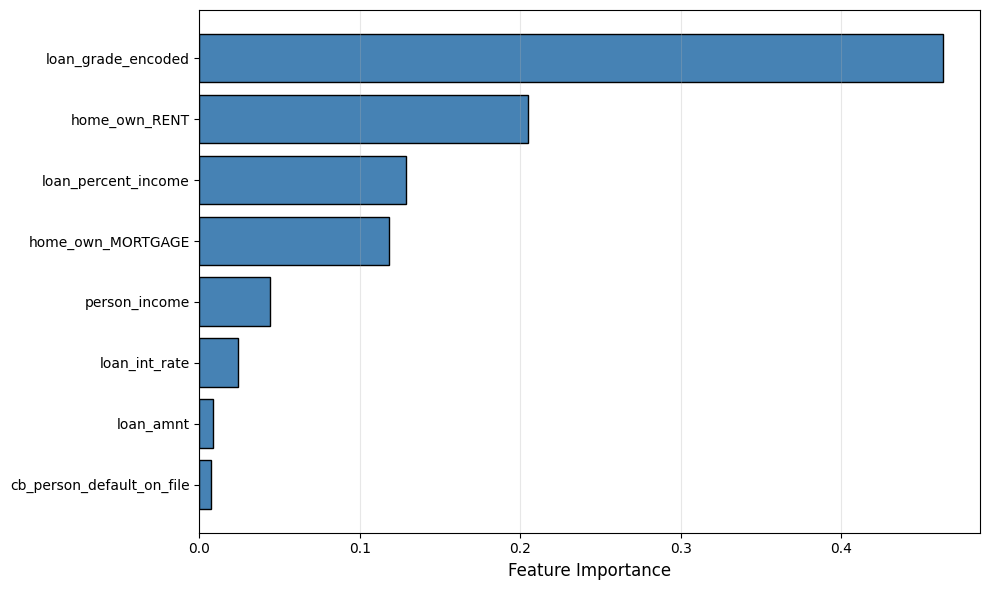

In [47]:
model_to_use = best_xgb
importances = model_to_use.feature_importances_
feature_names = X_train.columns

# Create DataFrame for easier visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print(f"TOP 10 MOST IMPORTANT FEATURES")
print(importance_df.head(10).to_string(index=False))

# Visualize top features
top_n = 10
top_features = importance_df.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue', edgecolor='black')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Feature Importance', fontsize=12)#
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## Conclusions and Model Performance Summary

### Feature Engineering and Selection
- **Preprocessing**: Encoded categorical variables using one-hot encoding (home ownership, loan intent), ordinal encoding (loan grade), and binary encoding (default history)
- **Feature Selection**: Reduced from 19 original features to 8 selected features using Mutual Information (MI > 0.01)
- **Selected Features**: `person_income`, `loan_percent_income`, `loan_grade_encoded`, `loan_int_rate`, `home_own_RENT`, `home_own_MORTGAGE`, `loan_amnt`, `cb_person_default_on_file`

### Model Performance Comparison

#### Baseline Models:
1. **Logistic Regression**: ROC AUC = 0.8577, F1 = 0.6155, Accuracy = 0.7901
2. **Random Forest**: ROC AUC = 0.9087, F1 = 0.7478, Accuracy = 0.8909
3. **XGBoost**: ROC AUC = 0.9254, F1 = 0.7481, Accuracy = 0.8854

#### Tuned Models:
1. **Logistic Regression (Tuned)**: ROC AUC = 0.8577, F1 = 0.6153, Accuracy = 0.7899
   - Best parameters: C=0.1, penalty='l2', solver='lbfgs'
   - Limited improvement, suggesting the baseline was already well-optimized

2. **Random Forest (Tuned)**: ROC AUC = 0.9103, F1 = 0.7479, Accuracy = 0.8917
   - Modest improvement from baseline
   - Tuning time: ~277 seconds

3. **XGBoost (Tuned)**: ROC AUC = 0.9310, F1 = 0.7473, Accuracy = 0.8826 ⭐ **BEST MODEL**
   - Best parameters: Optimized n_estimators, max_depth, learning_rate, subsample
   - Highest ROC AUC among all models
   - Tuning time: ~24 seconds (most efficient)

### Key Findings

1. **Best Model**: **XGBoost (Tuned)** achieves the highest discriminative ability with ROC AUC of 0.9310, indicating great ability to distinguish between default and non-default cases.

2. **Feature Importance**:
   - **Loan Grade** (`loan_grade_encoded`) is the most important feature (46.3%), confirming that loan rating is a primary risk indicator
   - **Home Ownership** (`home_own_RENT` at 20.5%, `home_own_MORTGAGE` at 11.8%) shows significant predictive power
   - **Loan Percent Income** (12.9%) indicates debt burden is a critical risk factor
   - **Person Income** (4.4%) and **Loan Interest Rate** (2.4%) provide additional predictive value

3. **Model Characteristics**:
   - Tree-based models (Random Forest, XGBoost) significantly outperform Logistic Regression
   - All models handle class imbalance well with appropriate techniques (class weights, scale_pos_weight)
   - XGBoost provides the best balance of performance and tuning efficiency

4. **Business Implications**:
   - The model can effectively identify high-risk loan applicants with ~93% discrimination ability
   - Loan grade and home ownership status are the most critical factors in default prediction
   - The model is production-ready for credit risk assessment with good predictive performance